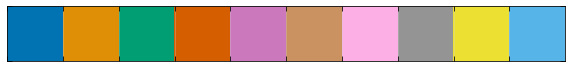

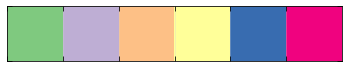

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import sys
from icecube import astro
sys.path.append('/home/apizzuto/Nova/scripts/')
from Novae import Nova
from helper_functions import *
from config import *
import pandas as pd
from numpy.lib.recfunctions import append_fields

import matplotlib as mpl
plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')

%matplotlib inline

sns.palplot(sns.color_palette('colorblind'))
palette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
sns.palplot(palette)

In [3]:
df = pd.read_pickle('/home/apizzuto/Nova/Novae_details_with_seasons.csv')
df = df.sort_values('Start Time (gamma ray)')

novae = []
seasons = []
for index, row in df.iterrows():
    a = Nova(row['Name'], -1.*row['SPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']),
            row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['SPL flux']*1e-7, cutoff = None)
    novae.append(a)
    seasons.append(row['GRECO season'])

nova = novae[1]
season = seasons[1]
if season == None:
    print("No valid GRECO data for nova {}".format(nova.name))

In [4]:
sigma = 30. * np.pi / 180.

In [5]:
llh = initialize_llh(nova, sigma = sigma, season=season)
inj = initialize_injector(nova, llh)

Initializing Point Source LLH in Skylab


/mnt/lfs3/user/apizzuto/software/skylab/skylab/llh_models.py:1135: UserWarning: Energy bins empty. Empty bins: [8.15478672e+00 1.29244660e+01 2.04838981e+01 3.24647907e+01
 5.14532258e+01 8.15478672e+01 1.29244660e+02 2.04838981e+02
 3.24647907e+02 5.14532258e+02 8.15478672e+02 1.29244660e+03
 2.04838981e+03 3.24647907e+03 5.14532258e+03 8.15478672e+03]
  warnings.warn(estr)


Initializing Point Source COMPLETE
LLH Initialization took 4.59238409996 seconds


Initializing Point Source Injector


Initializing Point Source LLH in Skylab
Initializing Point Source COMPLETE
LLH Initialization took 5.49621701241 seconds




(array([7864., 6555., 4876., 3739., 2874., 2237., 1792., 1414., 1126.,
         898.,  768.,  699.,  536.,  461.,  389.,  354.,  262.,  269.,
         208.]),
 array([0.        , 0.16534698, 0.33069396, 0.49604095, 0.66138793,
        0.82673491, 0.99208189, 1.15742887, 1.32277585, 1.48812284,
        1.65346982, 1.8188168 , 1.98416378, 2.14951076, 2.31485774,
        2.48020473, 2.64555171, 2.81089869, 2.97624567, 3.14159265]),
 <a list of 19 Patch objects>)

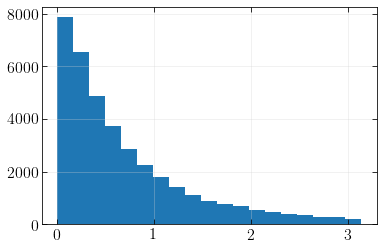

In [10]:
pllh = initialize_llh(nova, sigma = 'perfect', season=season)
plt.hist(pllh.exp['sigma'], bins = np.linspace(0., 180., 20)*np.pi / 180.)

In [6]:
results = None
nsigs = np.linspace(1, 20, 20)
#nsigs = np.linspace(1, 2, 2)
for nsig in nsigs:
    print nsig
    result = llh.do_trials(100, src_ra = nova.ra, src_dec = nova.dec, injector = inj, mean_signal=int(nsig), poisson=False)
    result = append_fields(result, 'mean_ninj', [nsig]*len(result), usemask=False)
    result = append_fields(result, 'flux', [inj.mu2flux(int(nsig))]*len(result), usemask=False)
    names = result.dtype.names
    names = list(names)
    names.remove('spectrum')
    result = result[names]
    if results == None:
        results = result
    else:
        results = np.append(results, result)

1.0
2.0


/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  del sys.path[0]


3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


In [7]:
results

array([( 1,  0.        ,  0.        ,  1., 1.10240403e-17),
       ( 1,  0.        ,  0.        ,  1., 1.10240403e-17),
       ( 1,  0.        ,  0.        ,  1., 1.10240403e-17), ...,
       (20,  5.81306519, 20.13317391, 20., 2.20480807e-16),
       (20, 21.42220834, 41.77030718, 20., 2.20480807e-16),
       (20,  5.09217538, 20.89024572, 20., 2.20480807e-16)],
      dtype={'names':['n_inj','TS','nsignal','mean_ninj','flux'], 'formats':['<i8','<f8','<f8','<f8','<f8'], 'offsets':[0,8,16,1048,1056], 'itemsize':1064})

In [6]:
bgts = llh.do_trials(1000, src_ra = nova.ra, src_dec = nova.dec, injector = inj, mean_signal=0, poisson=False)

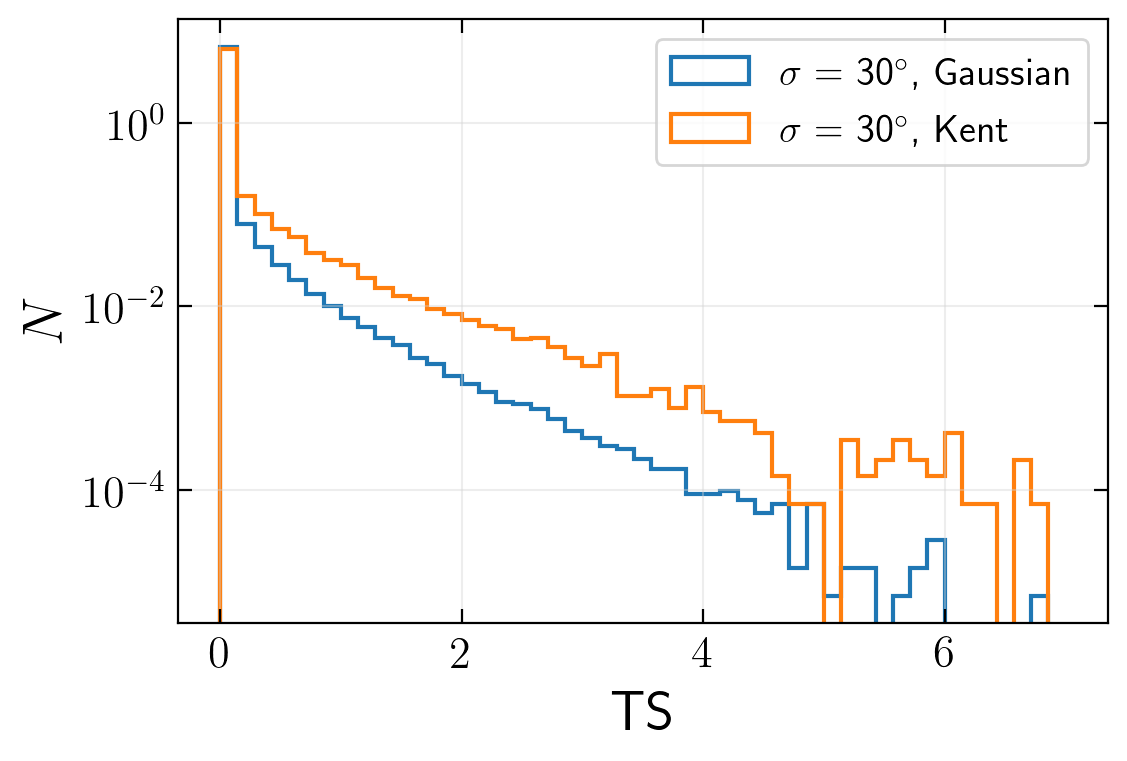

In [8]:
index = 1
spec = 'SPL'
fig, ax = plt.subplots(dpi = 200)
#sigma = '10'
for sigma in ['30']:
    trials = np.load('/data/user/apizzuto/Nova/analysis_trials/bg/index_{}_spec_{}_sigma_{}.npy'.format(index, spec, sigma),
               allow_pickle=True).item()
    plt.hist(trials['TS'], bins = np.linspace(0., 7., 50), histtype = 'step', density = True,
             linewidth = 1.5, label =r'$\sigma$ = {}'.format(sigma) + r'$^{\circ}$, Gaussian')

bgts = llh.do_trials(100000, src_ra = nova.ra, src_dec = nova.dec, injector = inj, mean_signal=0, poisson=False)    
plt.hist(bgts['TS'], bins = np.linspace(0., 7., 50), density = True,
         histtype = 'step', linewidth = 1.5, label =r'$\sigma$ = {}'.format(sigma) + r'$^{\circ}$, Kent')

plt.legend(loc = 1, fontsize = 14)
plt.xlabel("TS", fontsize = 20)
plt.ylabel(r'Probability Density', fontsize = 20)
plt.yscale('log')

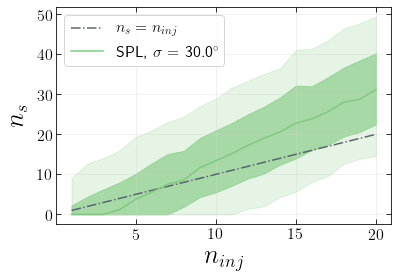

In [29]:
novnam = nova.name
novdec = nova.dec
spectrum = 'SPL'
sigmadeg = sigma * 180. / np.pi

fits = [results['nsignal'][results['n_inj'] == n] for n in np.linspace(1, 20, 20)]
lows_one = np.percentile(fits, 16, axis = 1)
lows_two = np.percentile(fits, 2.5, axis = 1)
meds = np.percentile(fits, 50, axis = 1)
highs_one = np.percentile(fits, 84, axis = 1)
highs_two = np.percentile(fits, 97.5, axis = 1)

ns = np.linspace(1, 20, 20)

plt.plot(ns, ns, ls = '-.', c = sns.xkcd_rgb['slate grey'], label = r'$n_s = n_{inj}$')
plt.fill_between(ns, lows_one, highs_one, color = palette[0], alpha = 0.6)
plt.fill_between(ns, lows_two, highs_two, color = palette[0], alpha = 0.2)
plt.plot(ns, meds, color = palette[0], label = r'{}, $\sigma$ = {}'.format(spectrum, sigmadeg) + r'$^{\circ}$')

plt.legend(loc = 2, fontsize = 16)
#plt.text(11, 3, r'$\Delta t$ = {:.2E} s'.format(deltaT))
#plt.text(11, 1, r'$\sin \delta$ = {}'.format(sinDec))
plt.xlabel(r'$n_{inj}$', fontsize = 26)
plt.ylabel(r'$n_{s}$', fontsize = 26)
plt.show()

In [30]:
results

array([( 1,  0.        ,  0.        ,  1., 1.10240403e-17),
       ( 1,  0.52065953,  7.19461418,  1., 1.10240403e-17),
       ( 1,  0.        ,  0.        ,  1., 1.10240403e-17), ...,
       (20, 15.54720584, 34.40606962, 20., 2.20480807e-16),
       (20, 12.97184725, 31.24118841, 20., 2.20480807e-16),
       (20, 18.78606254, 44.45685914, 20., 2.20480807e-16)],
      dtype={'names':['n_inj','TS','nsignal','mean_ninj','flux'], 'formats':['<i8','<f8','<f8','<f8','<f8'], 'offsets':[0,8,16,1048,1056], 'itemsize':1064})

On to the next
Initializing Point Source LLH in Skylab
Initializing Point Source COMPLETE
LLH Initialization took 4.433604002 seconds


Initializing Point Source Injector


/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


10.0
20.0


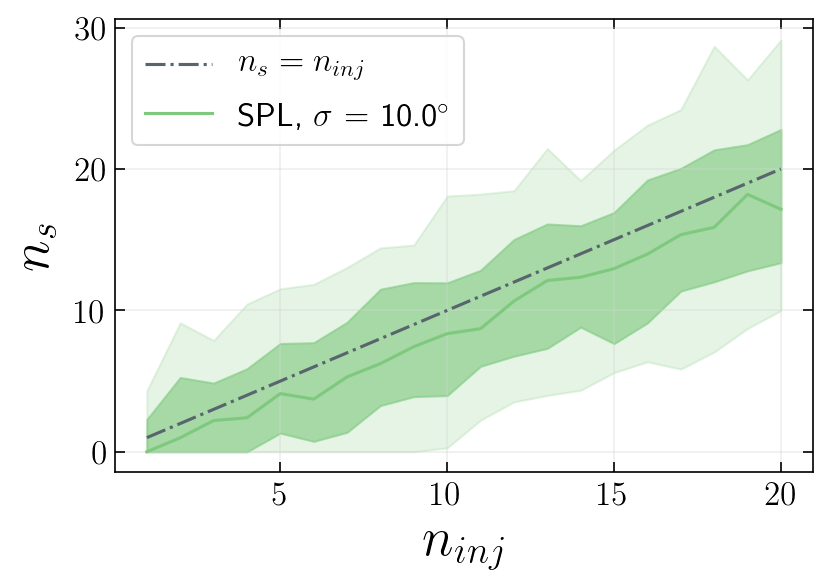

On to the next
Initializing Point Source LLH in Skylab
Initializing Point Source COMPLETE
LLH Initialization took 4.37886309624 seconds


Initializing Point Source Injector
10.0
20.0


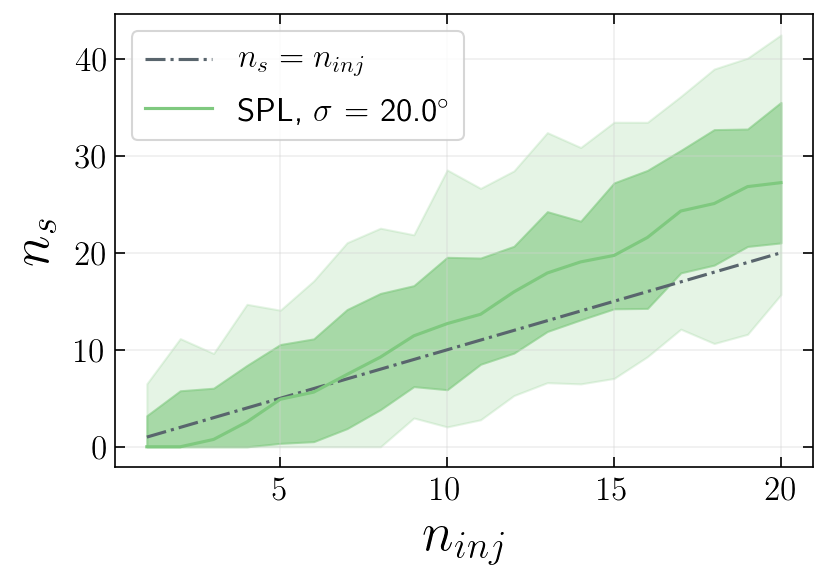

On to the next
Initializing Point Source LLH in Skylab
Initializing Point Source COMPLETE
LLH Initialization took 4.48555088043 seconds


Initializing Point Source Injector
10.0
20.0


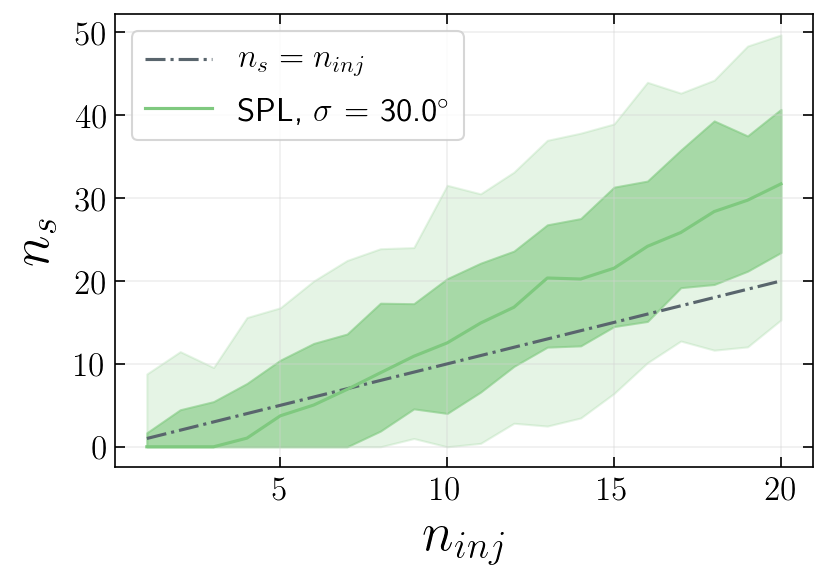

In [14]:
for sigmadeg in [10., 20., 30.]:
    print "On to the next"
    sigma = sigmadeg * np.pi / 180.
    llh = initialize_llh(nova, sigma = sigma, season=season)
    inj = initialize_injector(nova, llh)
    results = None
    nsigs = np.linspace(1, 20, 20)
    #nsigs = np.linspace(1, 2, 2)
    for nsig in nsigs:
        if nsig % 10 == 0:
            print nsig
        result = llh.do_trials(100, src_ra = nova.ra, src_dec = nova.dec, injector = inj, mean_signal=int(nsig), poisson=False)
        result = append_fields(result, 'mean_ninj', [nsig]*len(result), usemask=False)
        result = append_fields(result, 'flux', [inj.mu2flux(int(nsig))]*len(result), usemask=False)
        names = result.dtype.names
        names = list(names)
        names.remove('spectrum')
        result = result[names]
        if results == None:
            results = result
        else:
            results = np.append(results, result)
    novnam = nova.name
    novdec = nova.dec
    spectrum = 'SPL'

    fits = [results['nsignal'][results['n_inj'] == n] for n in np.linspace(1, 20, 20)]
    lows_one = np.percentile(fits, 16, axis = 1)
    lows_two = np.percentile(fits, 2.5, axis = 1)
    meds = np.percentile(fits, 50, axis = 1)
    highs_one = np.percentile(fits, 84, axis = 1)
    highs_two = np.percentile(fits, 97.5, axis = 1)

    ns = np.linspace(1, 20, 20)

    fig, ax = plt.subplots(dpi=150)
    plt.plot(ns, ns, ls = '-.', c = sns.xkcd_rgb['slate grey'], label = r'$n_s = n_{inj}$')
    plt.fill_between(ns, lows_one, highs_one, color = palette[0], alpha = 0.6)
    plt.fill_between(ns, lows_two, highs_two, color = palette[0], alpha = 0.2)
    plt.plot(ns, meds, color = palette[0], label = r'{}, $\sigma$ = {}'.format(spectrum, sigmadeg) + r'$^{\circ}$')

    plt.legend(loc = 2, fontsize = 16)
    plt.xlabel(r'$n_{inj}$', fontsize = 26)
    plt.ylabel(r'$n_{s}$', fontsize = 26)
    plt.show()

0.63652
0.96564


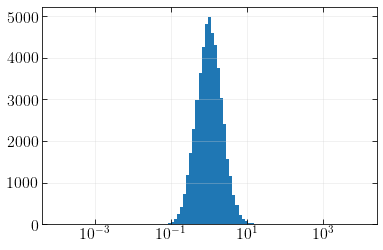

In [19]:
bins= np.logspace(-4., 4., 100)
rs = np.power(10., np.random.randn(50000) / 3. )
plt.hist(rs, bins = bins)
plt.xscale('log')
msk = rs > 0.5
msk *= rs < 2.0
print len(rs[msk]) / float(len(rs))
msk = rs > 0.2
msk *= rs < 5.
print len(rs[msk]) / float(len(rs))

On to the next
Initializing Point Source LLH in Skylab
Initializing Point Source COMPLETE
LLH Initialization took 5.32928204536 seconds


Initializing Point Source Injector
1.0
2.0


/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


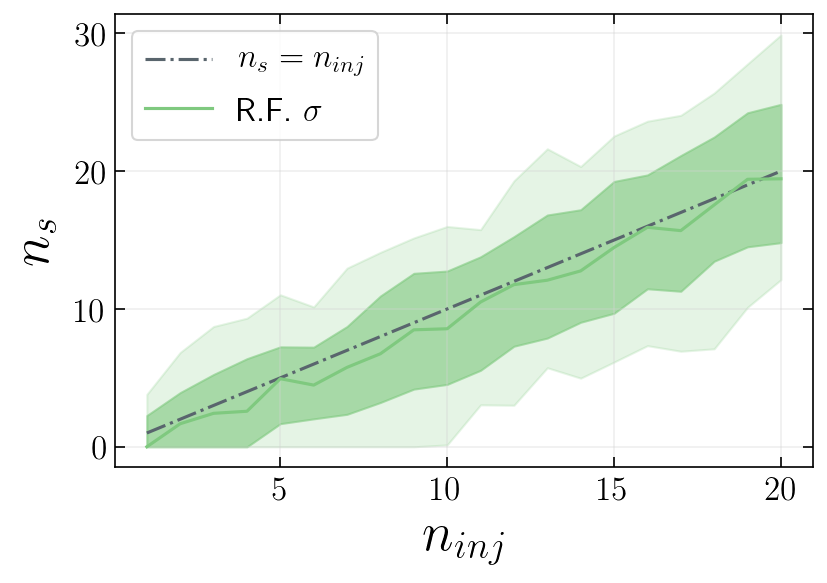

On to the next
Initializing Point Source LLH in Skylab
Initializing Point Source COMPLETE
LLH Initialization took 5.35606503487 seconds


Initializing Point Source Injector
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


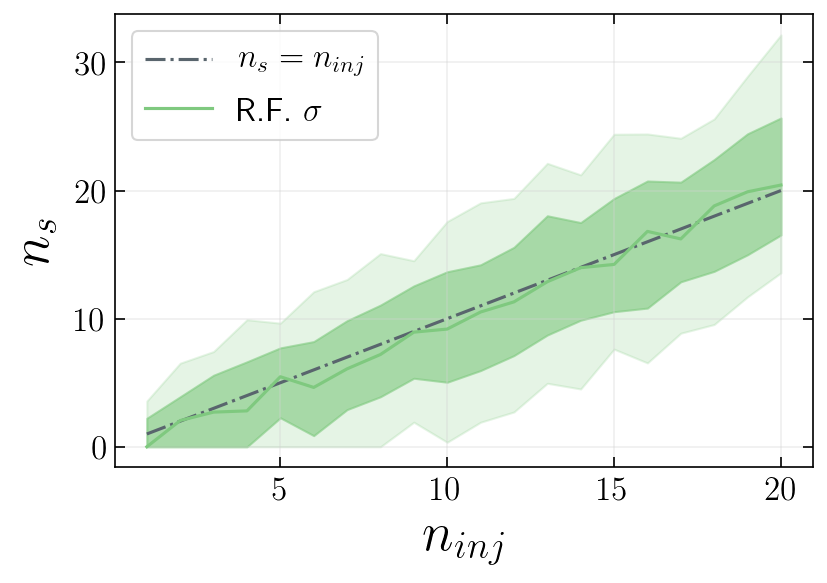

In [13]:
for pscale in [1., 1.177]:
    print "On to the next"
    #sigma = sigmadeg * np.pi / 180.
    llh = initialize_llh(nova, sigma = 'perfect', perfect_scale = pscale, season=season)
    inj = initialize_injector(nova, llh)
    results = None
    nsigs = np.linspace(1, 20, 20)
    #nsigs = np.linspace(1, 2, 2)
    for nsig in nsigs:
        print nsig
        result = llh.do_trials(100, src_ra = nova.ra, src_dec = nova.dec, injector = inj, mean_signal=int(nsig), poisson=False)
        result = append_fields(result, 'mean_ninj', [nsig]*len(result), usemask=False)
        result = append_fields(result, 'flux', [inj.mu2flux(int(nsig))]*len(result), usemask=False)
        names = result.dtype.names
        names = list(names)
        names.remove('spectrum')
        result = result[names]
        if results == None:
            results = result
        else:
            results = np.append(results, result)
    novnam = nova.name
    novdec = nova.dec
    spectrum = 'SPL'

    fits = [results['nsignal'][results['n_inj'] == n] for n in np.linspace(1, 20, 20)]
    lows_one = np.percentile(fits, 16, axis = 1)
    lows_two = np.percentile(fits, 2.5, axis = 1)
    meds = np.percentile(fits, 50, axis = 1)
    highs_one = np.percentile(fits, 84, axis = 1)
    highs_two = np.percentile(fits, 97.5, axis = 1)

    ns = np.linspace(1, 20, 20)

    fig, ax = plt.subplots(dpi=150)
    plt.plot(ns, ns, ls = '-.', c = sns.xkcd_rgb['slate grey'], label = r'$n_s = n_{inj}$')
    plt.fill_between(ns, lows_one, highs_one, color = palette[0], alpha = 0.6)
    plt.fill_between(ns, lows_two, highs_two, color = palette[0], alpha = 0.2)
    plt.plot(ns, meds, color = palette[0], label = r'R.F. $\sigma$')

    plt.legend(loc = 2, fontsize = 16)
    plt.xlabel(r'$n_{inj}$', fontsize = 26)
    plt.ylabel(r'$n_{s}$', fontsize = 26)
    plt.show()